> **Best algorithm comparison** \
> Comparison between TD3, SAC, and DSAC when controlling a LTI aircraft to track a sinusoidal pitch rate reference

# ⚙️ Set-up
Load required packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from helpers.paths import Path

sns.set()

Load a dataframe that contains the information from the algorithm's learning performance and a dataframe that contains the data from runing episodes with the learned agents

In [2]:
df_learn = pd.read_csv(Path.data/"best_algo_v2_learning.csv")
df_ep = pd.read_csv(Path.data/"best_algo_v2_episode.csv")

## Data checks

Number of unique learning for each algorithm

In [3]:
df_learn.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    30
SAC     30
TD3     30
dtype: int64

In [4]:
df_ep.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    30
SAC     30
TD3     30
dtype: int64

## Data treatment

Define function that smooths data

In [17]:
def make_smooth(_df, step=100, on=None, columns=None, group="run"):
    start = _df[on].min()
    stop = _df[on].max() + start
    info_list = []
    
    for run_name in df_learn[group].unique(): 
        # Get the name of the algorithm for the current run
        algorithm = _df.loc[_df[group]==run_name, "algorithm"].unique()[0]

        for t in np.arange(start, stop, step):
            mask = (_df[group]==run_name) & ((_df[on]>=t//2) & (_df[on]<t+step))
            run_slice = _df.loc[mask, columns]
            
            info = {"run": run_name, "step": t, "algorithm": algorithm}
            for column in columns:
                info[column] = run_slice[column].mean()
                
            info_list.append(info)
     
    return pd.DataFrame.from_records(info_list)

Smooth learning data

In [20]:
df_learn_smooth = make_smooth(df_learn, step=100, on="global_step", columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"])
df_ep_smooth = make_smooth(df_learn, step=100, on="episode_step", columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"])

# 👨🏽‍🏫 Learning performance

Each of the three algorithms were trained in 30 different random seeds. The results of the mean return and the episode length through the learning steps are shown bellow:

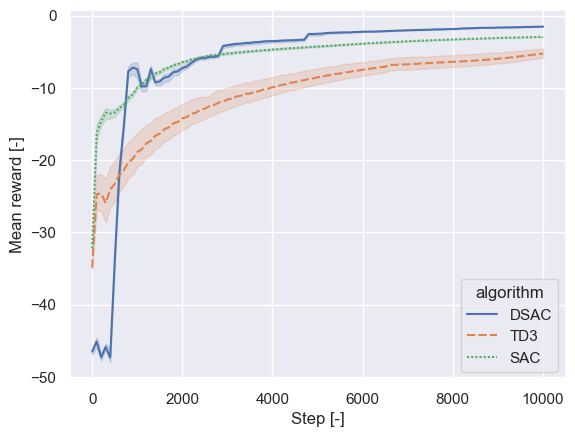

In [95]:
g = sns.lineplot(data=df_learn_smooth, x="step", y="rollout/ep_rew_mean", hue="algorithm", style="algorithm")
g.set(xlabel="Step [-]", ylabel="Mean return [-]");

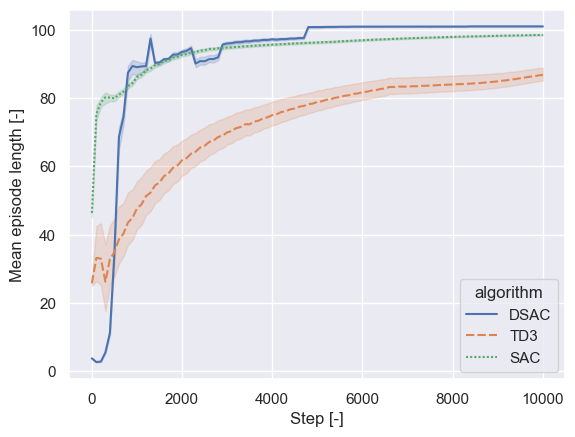

In [96]:
g = sns.lineplot(data=df_learn_smooth, x="step", y="rollout/ep_len_mean", hue="algorithm", style="algorithm")
g.set(xlabel="Step [-]", ylabel="Mean episode length [-]");

DSAC is the algorithm that, in average, reaches the highest return. SAC comes second, followed by TD3. In the first learning steps, TD3 and SAC lead in performance by having a quick rise in return. DSAC on the other hand, shows a longer rising time, only reaching the same performance of the other algorithms after approximatly 1000 steps. Overall, DSAC and SAC achive comparable performance. SAC with the advantage of having a quicker rise. However, it is important to reacall that those algorithms are intended to be part of the offline-trained part of the flight controller. In an offline setting, the  maximum return and consistency have a higher importance then learning quickly. This however, is not the case for the online-trained part, where the algorithm shall learn as quick as possible to adapt to the environment. 


A single episode in the studied tracking task ends after 100 steps. However, if the aircraft states is outside their acceptable range, the episode is terminated. The episode length plot shows that SAC and DSAC are consistent in learning to control the aircraft through the 100 steps. For the episodes of the TD3 agent, the average length of the episode is 85 steps. Therefore, this algorithm is not consistent in learning, where for some seeds it does not learn to control the aircraft through the entire episode length. The consistency of SAC and TD3 is also demosntraded by the low variance they exhibit, which is not the case for TD3.

# Episode analysis

In [149]:
df_ep_run = df_ep.groupby(["run", "algorithm"])[["reward", "tracking_error"]].sum().reset_index()

In [155]:
df_ep.groupby(["run", "algorithm"])["episode_step"].count().describe()

count     90.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: episode_step, dtype: float64

In [168]:
df_ep_run[df_ep_run.algorithm=="SAC"]["tracking_error"]

1     0.133976
2     0.133976
8     0.133976
9     0.133976
11    0.133976
12    0.133976
15    0.133976
17    0.133976
21    0.133976
22    0.133976
23    0.133976
25    0.035124
26    0.133976
31    0.133976
33    0.133976
37    0.133976
38    1.106331
42    0.133976
47    0.062263
51    0.133976
55    0.133976
62    0.133976
64    0.133976
66    0.133976
68    0.133976
74    0.133976
75    0.133976
78    0.294301
79    0.133976
85    1.368811
Name: tracking_error, dtype: float64

<AxesSubplot: xlabel='algorithm', ylabel='tracking_error'>

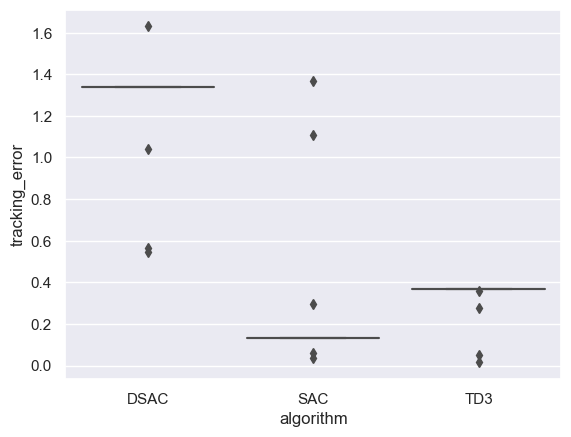

In [152]:
sns.boxplot(data=df_ep_run, x="algorithm", y="tracking_error")

In [138]:
# df_2 = df_ep.groupby(["run", "algorithm"]).sum().reset_index()
# # df_2.iloc[df_2.tracking_error.nlargest(10).index]
# df_2[df_2.algorithm=="DSAC"].sort_values(by="tracking_error").head(100)
df_learn[(df_learn.global_step >= 9000) & (df_learn.algorithm=="TD3")].sort_values("rollout/ep_rew_mean")

,Unnamed: 0,global_step,rollout/ep_len_mean,rollout/ep_rew_mean,algorithm,reward_type,run
293,107,9080,89.360001,-4.259640,TD3,sq_error,tough-morning-182
1505,107,9080,89.360001,-4.259640,TD3,sq_error,denim-rain-173
5949,107,9080,89.360001,-4.259640,TD3,sq_error,chocolate-sponge-140
5141,107,9080,89.360001,-4.259640,TD3,sq_error,gentle-armadillo-146
6353,107,9080,89.360001,-4.259640,TD3,sq_error,logical-elevator-137
...,...,...,...,...,...,...,...
11663,96,9797,101.000000,-0.107999,TD3,sq_error,fragrant-spaceship-98
11656,89,9090,101.000000,-0.107846,TD3,sq_error,fragrant-spaceship-98
11666,99,10100,101.000000,-0.107428,TD3,sq_error,fragrant-spaceship-98
11657,90,9191,101.000000,-0.107144,TD3,sq_error,fragrant-spaceship-98
